In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
from tqdm import tqdm
import gc
import os
TARGET = 'Label'

# Data

In [2]:
train = pd.read_csv('./input/Train.csv')
print(train.shape)
train.head()

(10864, 227)


,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
0,1,130,129,127,126,123,126,125,124,122,119,122,121,119,117,115,119,117,115,114,112,116,114,113,111,110,35.26439,37.29208,33.85452,35.79576,40.31554,38.87666,39.50971,40.51059,45.83452,45.00000,36.05503,40.51059,44.56372,41.81031,38.87666,33.85452,38.87666,33.85452,33.85452,32.63194,32.63194,30.24626,30.24626,30.24626,30.24626,98.1301,113.1986,116.5650,123.6901,135.0000,97.12502,104.0362,110.5560,119.0546,126.8699,105.9454,110.5560,113.9625,116.5650,119.7449,116.5650,119.7449,116.5650,116.5650,128.6598,128.6598,120.9638,120.9638,120.9638,120.9638,0.038514,0.029463,0.031405,0.025771,0.010453,0.028321,0.027360,0.019831,0.009338,0.008806,0.021451,0.021244,0.017273,0.006708,-0.008671,0.023851,0.012586,-0.004249,0.003646,-0.006809,0.013328,0.005337,0.007039,-0.017753,-0.007777,0.013903,0.014674,0.018249,0.018368,0.003341,0.002023,0.005743,0.002238,-0.003820,-0.003302,-0.002141,0.003585,0.002025,-0.012269,-0.027184,0.000977,-0.012630,-0.031644,-0.025683,-0.037371,-0.018934,-0.021875,-0.023553,-0.048495,-0.039092,8.045186,8.333038,7.819405,8.032228,9.818933,9.295772,9.375107,9.499450,10.922910,11.001900,9.339861,9.883230,11.035840,10.298030,9.618946,8.703197,10.175750,8.651121,8.251134,8.074524,8.519887,7.989215,7.634287,7.804186,7.219216,3.173340,2.961406,3.315935,3.061250,3.246914,3.221661,3.153512,3.048637,2.915506,3.073973,3.765278,3.246664,3.154479,3.237765,3.392537,3.851345,3.673898,3.821337,3.584646,3.734637,4.003083,4.218082,3.990867,4.100921,3.715154,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1.281767,1.281743,1.281708,1.281684,1.281649,1.281780,1.281757,1.281721,1.281698,1.281662,1.281789,1.281765,1.281730,1.281707,1.281671,1.281802,1.281779,1.281743,1.281720,1.281684,1.281811,1.281788,1.281752,1.281

In [3]:
test = pd.read_csv('./input/Test.csv')
orig = test.columns
print(test.shape)
test.head()

(5430, 226)


,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif
0,10865,111,109,109,110,112,117,114,113,112,113,120,120,118,116,115,122,122,122,121,120,122,122,121,121,123,45.83452,36.055030,27.01712,22.98977,27.01712,43.49152,49.490830,42.67464,30.96376,22.98977,27.017120,39.509710,44.56372,43.49152,35.26439,12.604380,11.309930,17.54840,28.30320,38.87666,5.710593,5.710593,8.049467,12.60438,26.56505,240.9454,254.05460,281.30990,315.00000,348.69010,251.56500,250.01690,257.47120,270.00000,315.00000,281.30990,255.96380,246.03750,251.56500,278.130100,296.56510,270.00000,251.56500,248.19860,277.125000,360.00000,180.00000,135.00000,333.43490,306.86990,0.035766,-0.013152,-0.037572,-0.062401,-0.055791,0.027593,0.002834,-0.038738,-0.052596,-0.035428,0.031410,0.010285,-0.030370,-0.047145,-0.030835,0.060269,0.010774,-0.009391,-0.030129,-0.029237,0.088753,0.075792,0.023841,-0.001485,-0.010110,-0.016483,-0.044767,-0.042420,-0.053476,-0.043530,0.008279,0.002710,-0.010917,-0.013603,-0.011500,0.026537,0.017282,-0.005495,-0.016250,-0.016121,0.074879,0.055460,0.042507,0.019065,-0.003870,0.024342,0.042834,0.056148,0.040106,0.021167,9.667106,8.181493,7.782584,8.776177,10.954420,8.896092,11.257830,10.227420,10.278770,8.030625,5.094675,8.138618,10.002860,11.459460,9.746919,1.718303,1.830190,4.348740,5.784863,10.840700,0.664827,0.000081,0.000261,0.846584,4.815838,2.682646,4.814003,6.252043,6.667844,6.602260,2.240095,2.561107,3.066897,5.311826,6.215635,2.774525,2.446323,2.663095,3.096692,4.132727,2.930157,4.044015,3.533233,2.135064,4.028785,4.076646,8.517193,9.857834,5.307338,3.319677,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1.310570,1.310638,1.310684,1.310752,1.310797,1.310388,1.310456,1.310502,1.310570,1.310616,1.310266,1.310335,1.310381,1.310449,1.310495,1.310084,1.310153,1.310199,1.310267,

In [5]:
train_ids = train['Sample_ID']
test_ids = test['Sample_ID']

full = pd.concat([train, test], axis=0)

In [6]:
del train, test
gc.collect()

51

# Feature Engineering

In [4]:
cols_types = np.unique([col.split('_')[-1] for col in orig[1:]])
cols_types

array(['aspect', 'elevation', 'geology', 'lsfactor', 'placurv', 'procurv',
       'sdoif', 'slope', 'twi'], dtype='<U9')

## Featues groups stats

In [8]:
for col in tqdm(cols_types):    
    cols = [c for c in orig if col in c]    
    df_agg = full[cols].agg(['mean', 'max', 'min', 'std', 'nunique', 'skew', 'kurt'], axis=1)
    df_agg.columns = [f'{col}_{c}' for c in df_agg.columns]
    full = pd.concat([full, df_agg], axis=1)    
    del df_agg
    gc.collect()
full.shape

100%|██████████| 9/9 [04:04<00:00, 27.19s/it]


(16294, 290)

In [9]:
full.head()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label,aspect_mean,aspect_max,aspect_min,aspect_std,aspect_nunique,aspect_skew,aspect_kurt,elevation_mean,elevation_max,elevation_min,elevation_std,elevation_nunique,elevation_skew,elevation_kurt,geology_mean,geology_max,geology_min,geology_std,geology_nunique,geology_skew,geology_kurt,lsfactor_mean,lsfactor_max,lsfactor_min,lsfactor_std,lsfactor_nunique,lsfactor_skew,lsfactor_kurt,placurv_mean,placurv_max,placurv_min,placurv_std,placurv_nunique,placurv_skew,placurv_kurt,procurv_mean,procurv_max,procurv_min,procurv_std,procurv_nunique,procurv_skew,procurv_kurt,sdoif_mean,sdoif_max,sdoif_min,sdoif_std,sdoif_nunique,sdoif_skew,sdoif_kurt,slope_mean,slope_max,slope_min,slope_std,slope_nunique,slope_skew,slope_kurt,twi_mean,twi_max,twi_min,twi_std,twi_nunique,twi_skew,twi_kurt
0,1,130,129,127,126,123,126,125,124,122,119,122,121,119,117,115,119,117,115,114,112,116,114,113,111,110,35.26439,37.29208,33.85452,35.79576,40.31554,38.87666,39.50971,40.51059,45.83452,45.00000,36.05503,40.51059,44.56372,41.81031,38.87666,33.85452,38.87666,33.85452,33.85452,32.63194,32.63194,30.24626,30.24626,30.24626,30.24626,98.1301,113.1986,116.5650,123.6901,135.0000,97.12502,104.0362,110.5560,119.0546,126.8699,105.9454,110.5560,113.9625,116.5650,119.7449,116.5650,119.7449,116.5650,116.5650,128.6598,128.6598,120.9638,120.9638,120.9638,120.9638,0.038514,0.029463,0.031405,0.025771,0.010453,0.028321,0.027360,0.019831,0.009338,0.008806,0.021451,0.021244,0.017273,0.006708,-0.008671,0.023851,0.012586,-0.004249,0.003646,-0.006809,0.013328,0.005337,0.007039,-0.017753,-0.007777,0.013903,0.014674,0.018249,0.018368,0.003341,0.002023,0.005743,0.002238,-0.003820,-0.003302,-0.002141,0.003585,0.002025,-0.012269,-0.027184,0.000977,-0.012630,-0.031644,-0.025683,

## Features relation to CELLID 13

In [10]:
for col in tqdm(cols_types):
    for i in range(1, 26, 1):
        if i == 13:
            continue
        full[f'{col}_13_diff_{i}'] = full[f'13_{col}'] - full[f'{i}_{col}']
        full[f'{col}_13_abs_diff_{i}'] = (full[f'13_{col}'] - full[f'{i}_{col}']).abs()
        full[f'{col}_13_/_{i}'] = full[f'13_{col}'] / full[f'{i}_{col}']
        full[f'{col}_13_x_{i}'] = full[f'13_{col}'] * full[f'{i}_{col}']
        
print(full.shape)

100%|██████████| 9/9 [00:00<00:00, 13.84it/s]

(16294, 1154)


## Inner grids stats

In [11]:
col = cols_types[0]
mat = np.arange(1, 26, 1).reshape(-5,5).T
print(mat)
grids = []
for i in range(4):
    for j in range(4):
        grids.append(mat[i:i+2, j:j+2].flatten())
grids

[[ 1  6 11 16 21]
 [ 2  7 12 17 22]
 [ 3  8 13 18 23]
 [ 4  9 14 19 24]
 [ 5 10 15 20 25]]


[array([1, 6, 2, 7]),
 array([ 6, 11,  7, 12]),
 array([11, 16, 12, 17]),
 array([16, 21, 17, 22]),
 array([2, 7, 3, 8]),
 array([ 7, 12,  8, 13]),
 array([12, 17, 13, 18]),
 array([17, 22, 18, 23]),
 array([3, 8, 4, 9]),
 array([ 8, 13,  9, 14]),
 array([13, 18, 14, 19]),
 array([18, 23, 19, 24]),
 array([ 4,  9,  5, 10]),
 array([ 9, 14, 10, 15]),
 array([14, 19, 15, 20]),
 array([19, 24, 20, 25])]

In [12]:
%%time
funcs = [np.max, np.min, np.sum]
fnames = ['max', 'min', 'sum']
for col in tqdm(cols_types):
    for i, cells in enumerate(grids):
        cols = [f'{cell}_{col}' for cell in cells]
        for func, name in zip(funcs, fnames):
            full[f'grid{i}_{col}_{name}'] = full[cols].apply(lambda x: func(x), axis=1)
full.head()

100%|██████████| 9/9 [08:53<00:00, 59.24s/it]


CPU times: user 8min 34s, sys: 18.3 s, total: 8min 53s
Wall time: 8min 53s


,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label,aspect_mean,aspect_max,aspect_min,aspect_std,aspect_nunique,aspect_skew,aspect_kurt,elevation_mean,elevation_max,elevation_min,elevation_std,elevation_nunique,elevation_skew,elevation_kurt,geology_mean,geology_max,geology_min,geology_std,geology_nunique,geology_skew,geology_kurt,lsfactor_mean,lsfactor_max,...,grid12_lsfactor_sum,grid13_lsfactor_max,grid13_lsfactor_min,grid13_lsfactor_sum,grid14_lsfactor_max,grid14_lsfactor_min,grid14_lsfactor_sum,grid15_lsfactor_max,grid15_lsfactor_min,grid15_lsfactor_sum,grid0_placurv_max,grid0_placurv_min,grid0_placurv_sum,grid1_placurv_max,grid1_placurv_min,grid1_placurv_sum,grid2_placurv_max,grid2_placurv_min,grid2_placurv_sum,grid3_placurv_max,grid3_placurv_min,grid3_placurv_sum,grid4_placurv_max,grid4_placurv_min,grid4_placurv_sum,grid5_placurv_max,grid5_placurv_min,grid5_placurv_sum,grid6_placurv_max,grid6_placurv_min,grid6_placurv_sum,grid7_placurv_max,grid7_placurv_min,grid7_placurv_sum,grid8_placurv_max,grid8_placurv_min,grid8_placurv_sum,grid9_placurv_max,grid9_placurv_min,grid9_placurv_sum,grid10_placurv_max,grid10_placurv_min,grid10_placurv_sum,grid11_placurv_max,grid11_placurv_min,grid11_placurv_sum,grid12_placurv_max,grid12_placurv_min,grid12_placurv_sum,grid13_placurv_max,grid13_placurv_min,grid13_placurv_sum,grid14_placurv_max,grid14_placurv_min,grid14_placurv_sum,grid15_placurv_max,grid15_placurv_min,grid15_placurv_sum,grid0_procurv_max,grid0_procurv_min,grid0_procurv_sum,grid1_procurv_max,grid1_procurv_min,grid1_procurv_sum,grid2_procurv_max,grid2_procurv_min,grid2_procurv_sum,grid3_procurv_max,grid3_procurv_min,grid3_procurv_sum,grid4_procurv_max,grid4_procurv_min,grid4_procurv_sum,grid5_procurv_max,grid5_procurv_min,grid5_procurv_sum,grid6_procurv_max,grid

## Rows stats and diffs to cell id 13

In [13]:
for col in tqdm(cols_types):    
    for i in range(1, 6, 1):
        cols = [f'{x}_{col}' for x in np.arange(i, i+21, 5)]
        
        full[f'{col}_row{i}_mean'] = full[cols].mean(axis=1)
        full[f'{col}_row{i}_std'] = full[cols].std(axis=1)
        full[f'{col}_row{i}_max'] = full[cols].max(axis=1)
        full[f'{col}_row{i}_min'] = full[cols].min(axis=1)
        
        full[f'{col}_row{i}_min_diff_13'] = full[f'13_{col}'] - full[f'{col}_row{i}_min']
        full[f'{col}_row{i}_max_diff_13'] = full[f'13_{col}'] - full[f'{col}_row{i}_max']
        full[f'{col}_row{i}_mean_diff_13'] = full[f'13_{col}'] - full[f'{col}_row{i}_mean']
        full[f'{col}_row{i}_std_diff_13'] = full[f'13_{col}'] - full[f'{col}_row{i}_std']
        
        full_cols_diff = full[cols].diff(axis=1)
        
        full[f'{col}_row{i}_diff_mean'] = full_cols_diff.mean(axis=1)
        full[f'{col}_row{i}_diff_std'] = full_cols_diff.std(axis=1)
        full[f'{col}_row{i}_diff_max'] = full_cols_diff.max(axis=1)
        full[f'{col}_row{i}_diff_min'] = full_cols_diff.min(axis=1)
        
        full[f'{col}_row{i}_diff_mean_diff_13'] = full[f'{col}_row{i}_diff_mean'] - full[f'13_{col}']
        full[f'{col}_row{i}_diff_std_diff_13'] = full[f'{col}_row{i}_diff_std'] - full[f'13_{col}']
        full[f'{col}_row{i}_diff_max_diff_13'] = full[f'{col}_row{i}_diff_max'] - full[f'13_{col}']
        full[f'{col}_row{i}_diff_min_diff_13'] = full[f'{col}_row{i}_diff_min'] - full[f'13_{col}']

100%|██████████| 9/9 [00:33<00:00,  3.71s/it]


## Columns stats and diffs to cell id 13

In [14]:
for col in tqdm(cols_types):    
    for j, i in enumerate(range(1, 22, 5)):
        cols = [f'{x}_{col}' for x in np.arange(i, i+5, 1)]
        
        full[f'{col}_col{j}_mean'] = full[cols].mean(axis=1)
        full[f'{col}_col{j}_std'] = full[cols].std(axis=1)
        full[f'{col}_col{j}_max'] = full[cols].max(axis=1)
        full[f'{col}_col{j}_min'] = full[cols].min(axis=1)
        
        full[f'{col}_col{j}_min_diff_13'] = full[f'13_{col}'] - full[f'{col}_col{j}_min']
        full[f'{col}_col{j}_max_diff_13'] = full[f'13_{col}'] - full[f'{col}_col{j}_max']
        full[f'{col}_col{j}_mean_diff_13'] = full[f'13_{col}'] - full[f'{col}_col{j}_mean']
        full[f'{col}_col{j}_std_diff_13'] = full[f'13_{col}'] - full[f'{col}_col{j}_std']
        
        full_col_diff = full[cols].diff(axis=1)
        
        full[f'{col}_col{i}_diff_mean'] = full_col_diff.mean(axis=1)
        full[f'{col}_col{i}_diff_std'] = full_col_diff.std(axis=1)
        full[f'{col}_col{i}_diff_max'] = full_col_diff.max(axis=1)
        full[f'{col}_col{i}_diff_min'] = full_col_diff.min(axis=1)
        
        full[f'{col}_col{i}_diff_mean_diff_13'] = full[f'{col}_col{i}_diff_mean'] - full[f'13_{col}']
        full[f'{col}_col{i}_diff_std_diff_13'] = full[f'{col}_col{i}_diff_std'] - full[f'13_{col}']
        full[f'{col}_col{i}_diff_max_diff_13'] = full[f'{col}_col{i}_diff_max'] - full[f'13_{col}']
        full[f'{col}_col{i}_diff_min_diff_13'] = full[f'{col}_col{i}_diff_min'] - full[f'13_{col}']

100%|██████████| 9/9 [00:46<00:00,  5.18s/it]


## Grouping by CellID 13 geology and extracting stats

In [15]:
for col in tqdm(cols_types):    
    cols = [c for c in orig if col in c]    
    df_agg = full.groupby(['13_geology'])[cols].agg(['mean', 'max', 'min', 'std', 'nunique'], axis=1)
    df_agg.columns = ['_13_geology_group_'.join(x) for x in df_agg.columns]
    for col in df_agg.columns:
        full[col] = full['13_geology'].map(df_agg[col])
    del df_agg
    gc.collect()

100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


## Frequency Encoding

In [16]:
train = full[full['Sample_ID'].isin(train_ids)]
test = full[full['Sample_ID'].isin(test_ids)].drop('Label', axis=1)
train['Label'] = train['Label'].astype(int)
del full
print(train.shape, test.shape)
display(train.head())
display(test.head())

(10864, 4151) (5430, 4150)


,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label,aspect_mean,aspect_max,aspect_min,aspect_std,aspect_nunique,aspect_skew,aspect_kurt,elevation_mean,elevation_max,elevation_min,elevation_std,elevation_nunique,elevation_skew,elevation_kurt,geology_mean,geology_max,geology_min,geology_std,geology_nunique,geology_skew,geology_kurt,lsfactor_mean,lsfactor_max,...,1_slope_13_geology_group_mean,1_slope_13_geology_group_max,1_slope_13_geology_group_min,1_slope_13_geology_group_std,1_slope_13_geology_group_nunique,2_slope_13_geology_group_mean,2_slope_13_geology_group_max,2_slope_13_geology_group_min,2_slope_13_geology_group_std,2_slope_13_geology_group_nunique,3_slope_13_geology_group_mean,3_slope_13_geology_group_max,3_slope_13_geology_group_min,3_slope_13_geology_group_std,3_slope_13_geology_group_nunique,4_slope_13_geology_group_mean,4_slope_13_geology_group_max,4_slope_13_geology_group_min,4_slope_13_geology_group_std,4_slope_13_geology_group_nunique,5_slope_13_geology_group_mean,5_slope_13_geology_group_max,5_slope_13_geology_group_min,5_slope_13_geology_group_std,5_slope_13_geology_group_nunique,6_slope_13_geology_group_mean,6_slope_13_geology_group_max,6_slope_13_geology_group_min,6_slope_13_geology_group_std,6_slope_13_geology_group_nunique,7_slope_13_geology_group_mean,7_slope_13_geology_group_max,7_slope_13_geology_group_min,7_slope_13_geology_group_std,7_slope_13_geology_group_nunique,8_slope_13_geology_group_mean,8_slope_13_geology_group_max,8_slope_13_geology_group_min,8_slope_13_geology_group_std,8_slope_13_geology_group_nunique,9_slope_13_geology_group_mean,9_slope_13_geology_group_max,9_slope_13_geology_group_min,9_slope_13_geology_group_std,9_slope_13_geology_group_nunique,10_slope_13_geology_group_mean,10_slope_13_geology_group_max,10_slope_13_geolo

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,aspect_mean,aspect_max,aspect_min,aspect_std,aspect_nunique,aspect_skew,aspect_kurt,elevation_mean,elevation_max,elevation_min,elevation_std,elevation_nunique,elevation_skew,elevation_kurt,geology_mean,geology_max,geology_min,geology_std,geology_nunique,geology_skew,geology_kurt,lsfactor_mean,lsfactor_max,lsfactor_min,...,1_slope_13_geology_group_mean,1_slope_13_geology_group_max,1_slope_13_geology_group_min,1_slope_13_geology_group_std,1_slope_13_geology_group_nunique,2_slope_13_geology_group_mean,2_slope_13_geology_group_max,2_slope_13_geology_group_min,2_slope_13_geology_group_std,2_slope_13_geology_group_nunique,3_slope_13_geology_group_mean,3_slope_13_geology_group_max,3_slope_13_geology_group_min,3_slope_13_geology_group_std,3_slope_13_geology_group_nunique,4_slope_13_geology_group_mean,4_slope_13_geology_group_max,4_slope_13_geology_group_min,4_slope_13_geology_group_std,4_slope_13_geology_group_nunique,5_slope_13_geology_group_mean,5_slope_13_geology_group_max,5_slope_13_geology_group_min,5_slope_13_geology_group_std,5_slope_13_geology_group_nunique,6_slope_13_geology_group_mean,6_slope_13_geology_group_max,6_slope_13_geology_group_min,6_slope_13_geology_group_std,6_slope_13_geology_group_nunique,7_slope_13_geology_group_mean,7_slope_13_geology_group_max,7_slope_13_geology_group_min,7_slope_13_geology_group_std,7_slope_13_geology_group_nunique,8_slope_13_geology_group_mean,8_slope_13_geology_group_max,8_slope_13_geology_group_min,8_slope_13_geology_group_std,8_slope_13_geology_group_nunique,9_slope_13_geology_group_mean,9_slope_13_geology_group_max,9_slope_13_geology_group_min,9_slope_13_geology_group_std,9_slope_13_geology_group_nunique,10_slope_13_geology_group_mean,10_slope_13_geology_group_max,10_slope_1

In [17]:
from collections import defaultdict

def transform_freq_feature(df1, df2, feat):
    val1 = df1[feat].values
    val2 = df2[feat].values

    defa1 = defaultdict(lambda: 0)

    for val in val1:
        defa1[str(val)] += 1.
    for val in val2:
        defa1[str(val)] += 1.  

    df1[feat + "_freq"] = df1[feat].apply(lambda x: defa1[str(x)]) 
    df2[feat + "_freq"] = df2[feat].apply(lambda x: defa1[str(x)]) 

for col in tqdm(test.columns):
    transform_freq_feature(train, test, col)
    
print(train.shape, test.shape)

100%|██████████| 4150/4150 [02:33<00:00, 27.04it/s]

(10864, 8301) (5430, 8300)


# Train Model

In [18]:
def get_best_f1_threshold(y_true, y_preds):
    precision, recall, thresholds = precision_recall_curve(y_true, y_preds)
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    return np.max(f1_scores), thresholds[np.argmax(f1_scores)]
    
def f1_loss(y_true, y_pred, beta=1) -> np.float32:
    '''Calculate F1 score.    
    The original implmentation is written by Michal Haltuf on Kaggle.    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6    
    '''     
    tp = (y_true * y_pred).sum()
    tn = ((1 - y_true) * (1 - y_pred)).sum()
    fp = ((1 - y_true) * y_pred).sum()
    fn = (y_true * (1 - y_pred)).sum()
    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = (1 + beta**2) * (precision*recall) / (beta**2 * precision + recall + epsilon)
    return f1 

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    f1, ths = get_best_f1_threshold(y_true, y_hat)
    return 'f1', f1, True

In [19]:
to_drop = ['Sample_ID', TARGET]
features = [ft for ft in test.columns if ft not in to_drop]
train_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
importances = pd.DataFrame(index=features)
scores = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idx, valid_idx) in enumerate(skf.split(train, train[TARGET])):
    
    x_train, x_val = train.iloc[train_idx][features], train.iloc[valid_idx][features]
    y_train, y_val = train.iloc[train_idx][TARGET], train.iloc[valid_idx][TARGET]
    
    dtrain = lightgbm.Dataset(x_train, y_train)
    dvalid = lightgbm.Dataset(x_val, y_val)

    params = {
        'boost': 'dart',
        'objective': 'binary',
        'learning_rate': 0.01,
        'max_depth': -1,
        'seed': 42,
        'feature_fraction': 0.65,
        'bagging_fraction': 0.75,
        'bagging_freq': 5,
        'verbosity': -1,
    }
    
    model = lightgbm.train(
        params,
        dtrain,
        num_boost_round=10_500,
        valid_sets=[dtrain, dvalid],
        verbose_eval=1000,
        feval=lgb_f1_score,
        early_stopping_rounds=1000
    )
    
    preds = model.predict(x_val, num_iteration=model.best_iteration)
    train_preds[valid_idx] = preds
    test_preds += model.predict(test[features], num_iteration=model.best_iteration)/skf.n_splits
    
    best_f1, best_t = get_best_f1_threshold(y_val, preds)
    scores.append(f1_loss(y_val, np.where(preds < best_t, 0, 1)))
    
    importances[i+1] = model.feature_importance()
    
    print('#'*25)
    print(f'# Fold {i+1}, F1: {scores[i]:.5f}')
    print('#'*25)
    
best_f1, best_t = get_best_f1_threshold(train[TARGET], train_preds)
print('#'*25)
print(f'# Full F1: {f1_loss(train[TARGET], np.where(train_preds < best_t, 0, 1)):.5f}')

[1000]	training's binary_logloss: 0.246236	training's f1: 0.891708	valid_1's binary_logloss: 0.332642	valid_1's f1: 0.730077
[2000]	training's binary_logloss: 0.141276	training's f1: 0.976403	valid_1's binary_logloss: 0.298736	valid_1's f1: 0.746903
[3000]	training's binary_logloss: 0.0904072	training's f1: 1	valid_1's binary_logloss: 0.291871	valid_1's f1: 0.750859
[4000]	training's binary_logloss: 0.056131	training's f1: 1	valid_1's binary_logloss: 0.292181	valid_1's f1: 0.754355
[5000]	training's binary_logloss: 0.0345009	training's f1: 1	valid_1's binary_logloss: 0.297089	valid_1's f1: 0.754522
[6000]	training's binary_logloss: 0.0221219	training's f1: 1	valid_1's binary_logloss: 0.303436	valid_1's f1: 0.757493
[7000]	training's binary_logloss: 0.0133791	training's f1: 1	valid_1's binary_logloss: 0.313805	valid_1's f1: 0.757194
[8000]	training's binary_logloss: 0.00787202	training's f1: 1	valid_1's binary_logloss: 0.326952	valid_1's f1: 0.760036
[9000]	training's binary_logloss: 0.

In [20]:
# Baseline:
# Folds F1: [0.72727, 0.71061, 0.69641, 0.73083, 0.72177]
# AVG F1: 0.71738
# FULL F1: 0.71049
# LB: 0.75462

# FE + Agg
# Folds F1: [0.73373, 0.74819, 0.72321, 0.73658, 0.73827]
# AVG F1: 0.73599
# FULL F1: 0.73016
# LB: 0.77599

# FE + Agg + Diff 13
# Folds F1: ['0.74415', '0.75000', '0.73786', '0.74874', '0.74735']
# AVG F1: 0.74562
# FULL F1: 0.74075
# LB: 0.7889733840304183

# Folds F1: ['0.75362', '0.76077', '0.74175', '0.75808', '0.73846']
# AVG F1: 0.75054
# FULL F1: 0.74567
# LB: 0.789x

# Folds F1: ['0.75575', '0.76349', '0.74291', '0.76910', '0.74627']
# AVG F1: 0.75550
# FULL F1: 0.74860
# LB: 0.790x

print(f'Folds F1: {[f"{x:.5f}" for x in scores]}')
print(f'AVG F1: {np.mean(scores):.5f}')
print(f'FULL F1: {f1_loss(train[TARGET], np.where(train_preds < best_t, 0, 1)):.5f}')

Folds F1: ['0.75575', '0.76349', '0.74291', '0.76910', '0.74627']
AVG F1: 0.75550
FULL F1: 0.74860


<AxesSubplot:>

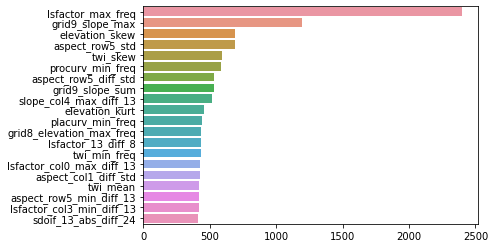

In [21]:
n = 20
importances_sorted = importances.mean(axis=1).sort_values(ascending=False).head(n)
sns.barplot(importances_sorted.values, importances_sorted.index)

In [22]:
sub = pd.read_csv('./input/SampleSubmission.csv')
sub['Label'] = np.where(test_preds < best_t, 0, 1)
sub.to_csv("sub-fe-5.csv", index=False)

In [23]:
df_train_preds = train[['Sample_ID']]
df_train_preds['Label'] = train_preds
df_train_preds.to_csv('./output/lgbm_train_preds.csv', index=False)

In [24]:
df_test_preds = sub.copy()
df_test_preds['Label'] = test_preds
df_test_preds.to_csv('./output/lgbm_test_preds.csv', index=False)